<a href="https://colab.research.google.com/github/complex-cgn/Pytorch-Noise-Methods/blob/main/NoiseEngine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

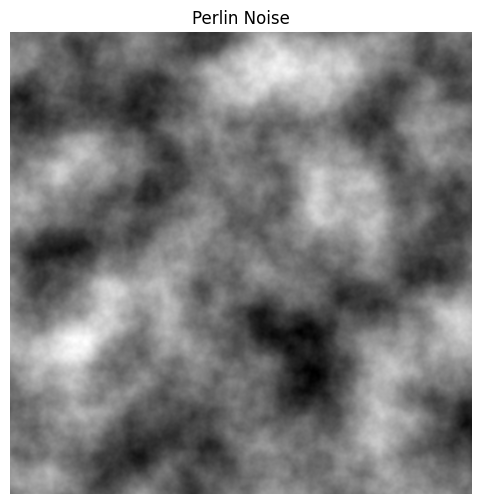

In [2]:
import logging
from dataclasses import dataclass, field
from typing import Optional
import os # Import os module

import matplotlib.pyplot as plt
import torch

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@dataclass
class Perlin:
    """
    A class for generating Perlin noise using PyTorch GPU acceleration.

    Attributes:
        width: Width of the noise grid
        height: Height of the noise grid
        scale: Spatial scale of the noise
        seed: Random seed for reproducibility
        device: Device to use for computation (cuda/cpu)
        grayscale: Whether to generate grayscale noise
    """

    width: int
    height: int
    scale: float = 4.0
    seed: Optional[int] = None
    device: torch.device = field(default_factory=lambda: torch.device(
        "cuda" if torch.cuda.is_available() else "cpu"
    ))
    grayscale: bool = True

    # Pre-allocated noise values for performance
    _n00: torch.Tensor = field(init=False)
    _n10: torch.Tensor = field(init=False)
    _n01: torch.Tensor = field(init=False)
    _n11: torch.Tensor = field(init=False)

    def __post_init__(self):
        """Initialize pre-allocated noise tensors."""
        self._n00 = torch.empty((self.height, self.width), device=self.device)
        self._n10 = torch.empty_like(self._n00)
        self._n01 = torch.empty_like(self._n00)
        self._n11 = torch.empty_like(self._n00)

        if self.seed is not None:
            torch.manual_seed(self.seed)

    @staticmethod
    def _fade(t: torch.Tensor) -> torch.Tensor:
        """
        Compute the fade curve for smooth interpolation.

        Uses the quintic polynomial: t³ * (t * (6*t - 15) + 10)

        Args:
            t: Input tensor in range [0, 1]

        Returns:
            Smoothed tensor in range [0, 1]
        """
        return t * t * t * (t * (t * 6 - 15) + 10)

    @staticmethod
    def _lerp(a: torch.Tensor, b: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Linear interpolation between two tensors.

        Args:
            a: First tensor
            b: Second tensor
            t: Interpolation factor in range [0, 1]

        Returns:
            Interpolated tensor
        """
        return a + t * (b - a)

    def _compute_noise_grid(self, seed: Optional[int], scale: float) -> torch.Tensor:
        """
        Compute Perlin noise for a single octave.

        Args:
            seed: Random seed for this octave
            scale: Spatial scale

        Returns:
            Noise tensor of shape (height, width)
        """
        # Get pre-allocated tensors
        n00, n10, n01, n11 = self._n00, self._n10, self._n01, self._n11

        # Create coordinate grid
        x_lin = torch.linspace(0, scale, self.width, device=self.device)
        y_lin = torch.linspace(0, scale, self.height, device=self.device)
        y, x = torch.meshgrid(y_lin, x_lin, indexing="ij")

        # Generate random rotation matrix
        grid_w = int(scale) + 2
        grid_h = int(scale) + 2
        rotation = torch.empty((grid_h, grid_w),
                               device=self.device).uniform_(0, 2 * torch.pi)

        # Convert coordinates to grid indices
        x0 = x.to(torch.int64)
        y0 = y.to(torch.int64)
        x1 = x0 + 1
        y1 = y0 + 1

        # Compute fractional parts
        xf = x - x0
        yf = y - y0

        # Compute dot products for each corner
        n00 = (rotation[y0, x0].cos() * xf +
               rotation[y0, x0].sin() * yf)
        n10 = (rotation[y0, x1].cos() * (xf - 1) +
               rotation[y0, x1].sin() * yf)
        n01 = (rotation[y1, x0].cos() * xf +
               rotation[y1, x0].sin() * (yf - 1))
        n11 = (rotation[y1, x1].cos() * (xf - 1) +
               rotation[y1, x1].sin() * (yf - 1))

        # Interpolate
        u = self._fade(xf)  # u is among to (0 - 1)
        value = self._lerp(
            self._lerp(n00, n10, u),
            self._lerp(n01, n11, u),
            self._fade(yf)
        )

        return value

    def fractal_noise_2d(
        self,
        octaves: int = 6,
        persistence: float = 0.5,
        lacunarity: float = 2.0,
        turbulence: bool = False,
    ) -> torch.Tensor:
        """
        Generate multi-octave Perlin noise.

        Args:
            octaves: Number of noise layers to sum
            persistence: Amplitude decay per octave (typically 0.5)
            lacunarity: Frequency multiplier per octave (typically 2.0)
            turbulence: Whether to use turbulence mode

        Returns:
            Combined noise tensor of shape (height, width)
        """
        total_noise = torch.zeros((self.height, self.width), device=self.device)
        current_scale = self.scale
        current_amp = 0.1

        for octave in range(octaves):
            layer_seed = self.seed + octave if self.seed is not None else None

            layer = self._compute_noise_grid(layer_seed, current_scale)

            if turbulence:
                gamma = 0.5
                layer = (torch.abs(layer) ** gamma) * current_amp
            else:
                layer = layer * current_amp

            total_noise += layer

            current_amp *= persistence
            current_scale *= lacunarity

        return total_noise

def generate_and_save_noise(
    width: int = 4096,
    height: int = 4096,
    scale: float = 4.0,
    octaves: int = 8,
    seed: Optional[int] = None,
    output_path: str = "noise.png",
    dpi: int = 150,
) -> None:
    """
    Generate Perlin noise and save it as an image.

    Args:
        width: Width of the noise grid
        height: Height of the noise grid
        scale: Spatial scale of the noise
        octaves: Number of noise layers
        seed: Random seed
        output_path: Path to save the output image
        dpi: Dots per inch for the output image
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create noise generator
    noise_generator = Perlin(
        width=width,
        height=height,
        scale=scale,
        seed=seed,
        device=device,
    )

    # Generate noise
    noise = noise_generator.fractal_noise_2d(octaves)

    # Ensure the output directory exists
    output_dir = os.path.dirname(output_path)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save as image
    plt.figure(figsize=(6, 6))
    plt.imshow(noise.cpu().numpy(), cmap="gray", origin="upper")
    plt.axis("off")
    plt.title("Perlin Noise")
    plt.savefig(output_path, dpi=dpi)
    plt.show()

    logger.info(f"Noise generated and saved to {output_path}")


if __name__ == "__main__":
    logger.info("Generating Perlin noise...")

    # Generate and save noise
    generate_and_save_noise(
        width=1024,
        height=1024,
        scale=4.0,
        octaves=6,
        output_path="outputs/noise.png",
        dpi=150,
    )
